In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
from accelerate.utils import ProjectConfiguration, set_seed

In [3]:
import torch
import random
import numpy as np

def set_seeds(seed):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [4]:
from torchvision import transforms
from diffusers import DDPMPipeline, DDIMPipeline, DDPMScheduler, DDIMScheduler, UNet2DModel

In [5]:
import pickle

In [6]:
class Args():
    
    model_config_name_or_path="config.json"
    
    dataset_name="cifar10"

    resolution=32
    center_crop=True
    random_flip=False

    dataloader_num_workers=8
    
    seed=42
    gen_seed=0    

    train_batch_size=256

    ddpm_num_steps=1000
    ddpm_num_inference_steps=50
    ddpm_beta_schedule='linear'

args=Args()
args.model_config_name_or_path

'config.json'

In [7]:
with open('./data/indices/5000-0.5/counter/idx-gen-sampled.pkl', 'rb') as handle:
    test_index = pickle.load(handle)
# test_index

In [8]:
with open("./counter/saved.pkl", 'rb') as handle:
    index_image_list = pickle.load(handle)

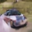

In [9]:
index_image_list[0][0][0]

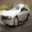

In [10]:
import pandas as pd
df = pd.DataFrame()
df['path'] = ['{}/{}.png'.format('./saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": df['path'].tolist(),
}).cast_column("img", Image()),})
gen_dataset = dataset["train"]
gen_dataset[0]['img']

In [11]:
len(index_image_list)

60

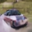

In [12]:
gen_images = [gen_dataset[i]['img'] for i in test_index]
gen_images[0]

In [13]:
random_images = [index_image_list[i][0][0] for i in range(60)]
len(random_images)

60

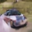

In [14]:
random_images[0]

In [15]:
trak_images = [index_image_list[i][0][1] for i in range(60)]
len(trak_images)

60

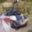

In [16]:
trak_images[0]

In [17]:
ours_images = [index_image_list[i][0][2] for i in range(60)]
len(ours_images)

60

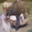

In [18]:
ours_images[0]

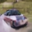

In [19]:
import pandas as pd

from datasets import DatasetDict, Dataset, load_dataset, Image

dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": gen_images,
})}
                     )
gen_dataset = dataset["train"]
gen_dataset[0]["img"]

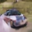

In [20]:
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": random_images,
})}
                     )
random_dataset = dataset["train"]
random_dataset[0]["img"]

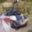

In [21]:
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": trak_images,
})}
                     )
trak_dataset = dataset["train"]
trak_dataset[0]["img"]

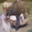

In [22]:
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": ours_images,
})}
                     )
ours_dataset = dataset["train"]
ours_dataset[0]["img"]

In [23]:
class Args():
    resolution=32
    center_crop=True
    random_flip=False
args=Args()

In [24]:
from torchvision import transforms

if True:
    augmentations = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
    def transform_images(examples):
        # images = [augmentations(image.convert("RGB")) for image in examples["image"]]
        images = [augmentations(image.convert("RGB")) for image in examples["img"]]
        return {"input": images}

    gen_dataset.set_transform(transform_images)
    
    random_dataset.set_transform(transform_images)
    
    trak_dataset.set_transform(transform_images)

    ours_dataset.set_transform(transform_images)

In [25]:
gen_features = torch.stack([gen_dataset[i]['input'] for i in range(60)]).reshape(-1, 3*32*32)
random_features = torch.stack([random_dataset[i]['input'] for i in range(60)]).reshape(-1, 3*32*32)
trak_features = torch.stack([trak_dataset[i]['input'] for i in range(60)]).reshape(-1, 3*32*32)
ours_features = torch.stack([ours_dataset[i]['input'] for i in range(60)]).reshape(-1, 3*32*32)

In [26]:
gen_features_array = gen_features.numpy()
random_features_array = random_features.numpy()
trak_features_array = trak_features.numpy()
ours_features_array = ours_features.numpy()

In [27]:
scores_list = []

In [28]:
gen_scores = np.linalg.norm(gen_features_array-gen_features_array, axis=1)
random_scores = np.linalg.norm(random_features_array-gen_features_array, axis=1)
trak_scores = np.linalg.norm(trak_features_array-gen_features_array, axis=1)
ours_scores = np.linalg.norm(ours_features_array-gen_features_array, axis=1)

In [29]:
random_scores.mean()

5.514583

In [30]:
np.median(random_scores)

4.712385

In [31]:
trak_scores.mean()

6.4391108

In [32]:
np.median(trak_scores)

5.901608

In [33]:
ours_scores.mean()

9.462168

In [34]:
np.median(ours_scores)

8.965666

In [35]:
df = pd.DataFrame()
df.head()
df['Random'] = random_scores
df['TRAK'] = trak_scores
df['D-TRAK'] = ours_scores
df.head()

,Random,TRAK,D-TRAK
0,2.788872,4.483785,7.861606
1,6.189478,6.249662,19.911118
2,3.807986,5.988188,7.086569
3,6.362907,5.454236,7.952570
4,6.149230,7.665555,6.885323
